# <center>ПРЕДСКАЗАНИЕ КОЭФФИЦИЕНТА ВОССТАНОВЛЕНИЯ ЗОЛОТА</center>

## <center>СБОРНЫЙ ПРОЕКТ ПО ML</center>
___
___

# <center>Описание проекта</center>

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

# <center>Описание данных</center>   

### Технологический процесс   
- `Rougher feed` — исходное сырье;   
- `Rougher additions` (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant;   
    - `Xanthate` **— ксантогенат (промотер, или активатор флотации);   
    - `Sulphate` — сульфат (на данном производстве сульфид натрия);   
    - `Depressant` — депрессант (силикат натрия).   
- `Rougher process` (англ. «грубый процесс») — флотация;   
- `Rougher tails` — отвальные хвосты;   
- `Float banks` — флотационная установка;   
- `Cleaner process` — очистка;   
- `Rougher Au` — черновой концентрат золота;   
- `Final Au` — финальный концентрат золота.

### Параметры этапов   
- `air amount` — объём воздуха;   
- `fluid levels` — уровень жидкости;   
- `feed size` — размер гранул сырья;   
- `feed rate` — скорость подачи.

### Наименование признаков   

Возможные значения для блока `этап`:   
- `rougher` — флотация;   
- `primary_cleaner` — первичная очистка;   
- `secondary_cleaner` — вторичная очистка;   
- `final` — финальные характеристики.

Возможные значения для блока `тип_параметра`:   
- `input` — параметры сырья;   
- `output` — параметры продукта;   
- `state` — параметры, характеризующие текущее состояние этапа;   
- `calculation` — расчётные характеристики.   

<a id = 'back'></a>
# <center>Состав работ</center>

[1. Подготовка данных](#1)   

   - [1.1. Открытие и изучение файлов](#1.1)
   - [1.2. Проверка правильности вычисления эффективности обогащения](#1.2)
   - [1.3. Анализ признаков, недоступных в тестовой выборке](#1.3)
   - [1.4. Предобработка данных](#1.4)

[2. Анализ данных](#2)   

   - [2.1. Анализ изменения концентрации металлов на различных этапах очистки](#2.1)
   - [2.2. Сравнение распределения размеров гранул сырья на выборках](#2.2)
   - [2.3. Исследование суммарной концентрации всех веществ на разных стадиях процесса](#2.3)

[3. Построение модели](#3)   

   - [3.1. Функция для вычисления итоговой sMAPE](#3.1)
   - [3.2. Обучение моделей и оценка качества кросс-валидацией](#3.2)

### <center>Блок импорта необходимых библиотек</center>

In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import statistics
from sklearn.model_selection import cross_val_score
import math

<a id = '1'></a>
# 1. Подготовка данных
___
___

<a id = '1.1'></a>
### 1.1. Открытие и изучение файлов
___

Записываем файлы в переменные.

In [2]:
gold_recovery_train = pd.read_csv('/datasets/gold_recovery_train.csv')
gold_recovery_test = pd.read_csv('/datasets/gold_recovery_test.csv')
gold_recovery_full = pd.read_csv('/datasets/gold_recovery_full.csv')

Смотрим основную информацию по файлам.

In [3]:
gold_recovery_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

In [4]:
gold_recovery_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

In [5]:
gold_recovery_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

Да, есть с чем работать. Посмотрим ещё, что в принципе записано в данных.

In [6]:
gold_recovery_full.sample(10)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
22386,2018-08-04 17:59:59,5.471107,8.353153,10.487912,44.332332,71.411018,17.834689,5.039124,8.379990,3.992077,...,22.012737,-500.937048,17.115284,-500.229204,17.045620,-500.365802,12.994377,-500.241308,17.986214,-580.180524
16120,2017-11-16 15:59:59,4.834565,8.962794,8.791918,46.845382,78.332003,9.349459,1.071752,13.110245,2.105126,...,17.009814,-499.753671,11.842141,-500.536883,10.887669,-499.011828,8.998381,-499.896369,15.990922,-499.103080
9129,2017-01-29 08:59:59,5.217989,11.238640,15.238428,43.749006,68.922440,12.922286,5.437724,8.985606,4.546016,...,21.039091,-503.117994,20.970665,-501.149993,23.015815,-500.239163,19.994926,-499.854315,25.000414,-600.304728
10809,2017-04-09 08:59:59,4.302695,11.593116,9.889701,45.445581,67.413726,7.530674,2.893294,13.498720,2.580055,...,24.982288,-399.401458,23.061776,-399.332781,26.025232,-449.875252,23.991975,-450.027220,29.995611,-500.253967
17708,2018-01-21 19:59:59,5.425836,9.943033,9.285745,44.583037,72.811169,11.795530,2.203559,1.717443,3.283493,...,19.974392,-499.046344,15.045950,-499.738267,10.915680,-499.465842,8.941993,-500.126782,10.999206,-499.877283
15088,2017-10-04 15:59:59,4.468843,12.070772,6.562945,45.437746,69.684760,6.627131,2.907338,10.904360,2.449840,...,13.984409,-500.202445,11.979024,-399.562515,12.908435,-500.693720,11.034275,-500.151919,14.987436,-500.621765
13429,2017-07-27 12:59:59,5.171873,9.414320,7.652618,45.424750,58.687148,7.306760,2.568317,10.698160,2.648771,...,16.988543,-500.420877,10.130104,-399.813994,15.960424,-500.470476,10.020497,-500.004834,15.020971,-500.517153
6571,2016-10-14 18:59:59,8.148908,9.729092,13.053261,41.819935,65.151840,13.022489,3.973248,10.816140,5.325649,...,15.935780,-501.297491,12.023995,-501.190930,8.851305,-499.883187,7.969385,-499.865790,16.999865,-500.275869
15657,2017-10-28 08:59:59,6.104732,9.387308,9.848711,45.672546,72.452418,14.112841,4.035868,11.807043,3.577933,...,17.961120,-500.518509,16.047757,-499.999077,15.002268,-500.368408,10.985542,-499.865816,15.982678,-500.289935
16483,2017-12-01 18:59:59,5.754246,8.952719,12.259699,45.267202,70.014219,11.306325,1.783178,14.195851,3.495826,...,17.008991,-497.085408,14.929738,-402.045323,11.012779,-499.934037,9.007975,-499.343940,22.999646,-500.797324


В принципе остальные смотреть нет смысла - колонки такие же.   
Сразу наблюдение: некоторые строки с большим количеством нулевых значений и пока только в таких строках попался 'NaN'. Может это и не важно но запомним и дальше посмотрим.   
Выведем краткий статистический анализ по данным, опыт показывает, что в дальнейшем может пригодиться.

In [7]:
gold_recovery_train.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,16788.000000,16788.000000,16490.000000,16789.000000,15339.000000,16794.000000,16677.000000,16715.000000,16794.000000,15553.000000,...,16731.000000,16747.000000,16768.000000,16767.000000,16775.000000,16775.000000,16775.000000,16776.000000,16757.000000,16775.000000
mean,4.716907,9.113559,8.301123,39.467217,67.213166,8.757048,2.360327,9.303932,2.687512,129.479789,...,19.101874,-494.164481,14.778164,-476.600082,15.779488,-500.230146,12.377241,-498.956257,18.429208,-521.801826
std,2.096718,3.389495,3.825760,13.917227,11.960446,3.634103,1.215576,4.263208,1.272757,45.386931,...,6.883163,84.803334,5.999149,89.381172,6.834703,76.983542,6.219989,82.146207,6.958294,77.170888
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.021781,-0.423260,-799.741097,0.427084,-800.258209,0.024270,-810.473526
25%,3.971262,8.825748,6.939185,42.055722,62.625685,7.610544,1.641604,7.870275,2.172953,103.064021,...,14.508299,-500.837689,10.741388,-500.269182,10.977713,-500.530594,8.925586,-500.147603,13.977626,-501.080595
50%,4.869346,10.065316,8.557228,44.498874,67.644601,9.220393,2.453690,10.021968,2.781132,131.783108,...,19.986958,-499.778379,14.943933,-499.593286,15.998340,-499.784231,11.092839,-499.933330,18.034960,-500.109898
75%,5.821176,11.054809,10.289741,45.976222,72.824595,10.971110,3.192404,11.648573,3.416936,159.539839,...,24.983961,-494.648754,20.023751,-400.137948,20.000701,-496.531781,15.979467,-498.418000,24.984992,-499.565540
max,16.001945,17.031899,18.124851,53.611374,100.000000,19.552149,6.086532,22.317730,9.789625,251.999948,...,60.000000,-127.692333,28.003828,-71.472472,63.116298,-275.073125,39.846228,-120.190931,54.876806,-39.784927


In [8]:
gold_recovery_test.describe()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5554.000000,5572.000000,5856.000000,5690.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,...,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000
mean,170.515243,8.482873,7.264651,1.321420,1481.990241,-509.057796,1486.908670,-511.743956,1468.495216,-509.741212,...,15.636031,-516.266074,13.145702,-476.338907,12.308967,-512.208126,9.470986,-505.017827,16.678722,-512.351694
std,49.608602,3.353105,0.611526,0.693246,310.453166,61.339256,313.224286,67.139074,309.980748,62.671873,...,4.660835,62.756748,4.304086,105.549424,3.762827,58.864651,3.312471,68.785898,5.404514,69.919839
min,0.000103,0.000031,5.650000,0.000003,0.000000,-799.773788,0.000000,-800.029078,0.000000,-799.995127,...,0.000000,-799.798523,0.000000,-800.836914,-0.223393,-799.661076,0.528083,-800.220337,-0.079426,-809.859706
25%,143.340022,6.411500,6.885625,0.888769,1497.190681,-500.455211,1497.150234,-500.936639,1437.050321,-501.300441,...,12.057838,-501.054741,11.880119,-500.419113,10.123459,-500.879383,7.991208,-500.223089,13.012422,-500.833821
50%,176.103893,8.023252,7.259333,1.183362,1554.659783,-499.997402,1553.268084,-500.066588,1546.160672,-500.079537,...,17.001867,-500.160145,14.952102,-499.644328,12.062877,-500.047621,9.980774,-500.001338,16.007242,-500.041085
75%,207.240761,10.017725,7.650000,1.763797,1601.681656,-499.575313,1601.784707,-499.323361,1600.785573,-499.009545,...,18.030985,-499.441529,15.940011,-401.523664,15.017881,-499.297033,11.992176,-499.722835,21.009076,-499.395621
max,274.409626,40.024582,15.500000,5.433169,2212.432090,-57.195404,1975.147923,-142.527229,1715.053773,-150.937035,...,30.051797,-401.565212,31.269706,-6.506986,25.258848,-244.483566,14.090194,-126.463446,26.705889,-29.093593


In [9]:
gold_recovery_full.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,22627.000000,22629.000000,22331.000000,22630.000000,20753.000000,22633.000000,22516.000000,22445.000000,22635.000000,21107.000000,...,22571.000000,22587.000000,22608.000000,22607.000000,22615.000000,22615.000000,22615.000000,22616.000000,22597.000000,22615.000000
mean,4.781559,9.095308,8.640317,40.001172,67.447488,8.923690,2.488252,9.523632,2.827459,140.277672,...,18.205125,-499.878977,14.356474,-476.532613,14.883276,-503.323288,11.626743,-500.521502,17.976810,-519.361465
std,2.030128,3.230797,3.785035,13.398062,11.616034,3.517917,1.189407,4.079739,1.262834,49.919004,...,6.560700,80.273964,5.655791,93.822791,6.372811,72.925589,5.757449,78.956292,6.636203,75.477151
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.836914,-0.423260,-799.741097,0.427084,-800.258209,-0.079426,-810.473526
25%,4.018525,8.750171,7.116799,42.383721,63.282393,7.684016,1.805376,8.143576,2.303108,110.177081,...,14.095940,-500.896232,10.882675,-500.309169,10.941299,-500.628697,8.037533,-500.167897,13.968418,-500.981671
50%,4.953729,9.914519,8.908792,44.653436,68.322258,9.484369,2.653001,10.212998,2.913794,141.330501,...,18.007326,-499.917108,14.947646,-499.612292,14.859117,-499.865158,10.989756,-499.951980,18.004215,-500.095463
75%,5.862593,10.929839,10.705824,46.111999,72.950836,11.084557,3.287790,11.860824,3.555077,174.049914,...,22.998194,-498.361545,17.977502,-400.224147,18.014914,-498.489381,14.001193,-499.492354,23.009704,-499.526388
max,16.001945,17.031899,19.615720,53.611374,100.000000,19.552149,6.086532,22.861749,9.789625,274.409626,...,60.000000,-127.692333,31.269706,-6.506986,63.116298,-244.483566,39.846228,-120.190931,54.876806,-29.093593


Ну что ж, пока можно сказать следующее:
- типы данных соответствуют представленным значениям;
- выявлены пропуски в данных, в целом не так много, однако по беглому осмотру в нескольких колонках отсутствует примерно до 13% данных.

___
[*К содержанию*](#back)

<a id = '1.2'></a>
### 1.2. Проверка правильности вычисления эффективности обогащения
___

Для проверки правильности вычисления определимся со следующим:   
- проверяемый признак: rougher.output.recovery;   
- расчётная формула: ((C * (F - T)) / (F * (C-T))) * 100%;   
- обозначения в формуле соответствуют следующему:   
    - C - rougher.output.concentrate_au (доля золота в концентрате после флотации/очистки);   
    - F - rougher.input.feed_au (доля золота в сырье/концентрате до флотации/очистки);   
    - T - rougher.output.tail_au (доля золота в отвальных хвостах после флотации/очистки).
    
Для удобства сначала запишем эти признаки в соответствующие переменные.

In [10]:
c = gold_recovery_train['rougher.output.concentrate_au']
f = gold_recovery_train['rougher.input.feed_au']
t = gold_recovery_train['rougher.output.tail_au']
recovery_check = 100 * (c * (f - t))/(f * (c-t))
calc_df = pd.DataFrame({'true_recovery': gold_recovery_train['rougher.output.recovery'],
                        'calc_recovery': recovery_check})

Рассчитали по формуле `Recovery`, объединили в один df для удобства. Мае рассчитаем вручную, а не средствами sklearn, чтобы не дропать nan-ы, inf-ы и т.д.

In [11]:
print(sum(abs(calc_df['true_recovery'] - calc_df['calc_recovery']).fillna(0)) / len(calc_df))

9.235396156801791e-15


Вывод: явно видно что MAE у нас стремится к нулю, что, в наем случае, свидетельствует о правильности рассчитанной эффективности обогащения в представленных данных. Едем дальше.

___
[*К содержанию*](#back)

<a id = '1.3'></a>
### 1.3. Анализ признаков, недоступных в тестовой выборке
___

Ранее сделанный вывод методом `info()` показал что колонки имеют одинаковое название, но не в каждом наборе данных их одинаковое количество. Для анализа признаков, недоступных в тестовой выборке, создадим отдельный список, в котором запишем эти признаки. Можно сравнивать как с тренировочным надором данных, так и с полным, так как количество признаков в этих наборах одинаково (на всякий случай проверим ниже).

In [12]:
difference_count = 0
for i in range(len(gold_recovery_train.columns)):
    if (gold_recovery_train.columns[i] not in gold_recovery_full.columns):
        difference_count += 1
        
print(difference_count)
    

0


Как и говорилось выше, колонки полностью совпадают. Теперь сравниваем с тестовой выборкой.

In [13]:
different_column_list = []
for i in range(len(gold_recovery_train.columns)):
    if (gold_recovery_train.columns[i] not in gold_recovery_test.columns):
        different_column_list.append(gold_recovery_train.columns[i])
        
print(pd.Series(different_column_list))

0                           final.output.concentrate_ag
1                           final.output.concentrate_pb
2                          final.output.concentrate_sol
3                           final.output.concentrate_au
4                                 final.output.recovery
5                                  final.output.tail_ag
6                                  final.output.tail_pb
7                                 final.output.tail_sol
8                                  final.output.tail_au
9                 primary_cleaner.output.concentrate_ag
10                primary_cleaner.output.concentrate_pb
11               primary_cleaner.output.concentrate_sol
12                primary_cleaner.output.concentrate_au
13                       primary_cleaner.output.tail_ag
14                       primary_cleaner.output.tail_pb
15                      primary_cleaner.output.tail_sol
16                       primary_cleaner.output.tail_au
17        rougher.calculation.sulfate_to_au_conc

Видим следующее, отсутствующие признаки:
- относятся к каждому этапу производственного цикла. При этом интересно, что для вторичной очистки отсутствуют данные, только по отвальным хвостам. Хотя это и логично, так как после второй очистки мы получаем финальные концентрации (в тестовых данных, кстати, тоже отсутствуют);
- по типам параметра отсутствуют только параметры продукта и расчетные характеристики. Необхидимо обратить внимание и запомнить: видимо далее их придется либо рассчитывать, либо предсказывать по параметрам сырья;
- кроме того, как было указано в ТЗ: "Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков".

Нам в тестовую выборку надо из полной вытащить недостающие колонки. Сделаем это методом `merge` по дате. Предварительно удалим колонки, которые уже есть в тестовой выборке.

In [14]:
#col_list = gold_recovery_test.drop('date', axis = 1).columns

In [15]:
#merge_data = gold_recovery_full.drop(col_list, axis = 1)

In [16]:
#gold_recovery_test = gold_recovery_test.merge(merge_data, on = 'date')

In [17]:
#gold_recovery_test.info()

Перед удалением колонок из тренировочной выборки добавим в тестовую целевые признаки из полного набора данных.

In [18]:
#merge_data = gold_recovery_full[['date', 'rougher.output.recovery', 'final.output.recovery']]
#gold_recovery_test = gold_recovery_test.merge(merge_data, on = 'date')

In [19]:
#col_list_test = gold_recovery_test.columns
#col_list_train = gold_recovery_train.columns
#for column in col_list_train:
#    if column not in col_list_test:
#        gold_recovery_train.drop(column, axis = 1, inplace = True)

___
[*К содержанию*](#back)

<a id = '1.4'></a>
### 1.4. Предобработка данных
___

В первую очередь предлагается изменить тип в колонке `date` на *datetime*. Указано что соседние по времени параметры часто похожи, возможно это пригодится при заполнении пропусков.

In [20]:
gold_recovery_train['date'] = pd.to_datetime(gold_recovery_train['date'], format = '%Y.%m.%d %H:%M:%S')
gold_recovery_test['date'] = pd.to_datetime(gold_recovery_test['date'], format = '%Y.%m.%d %H:%M:%S')
gold_recovery_full['date'] = pd.to_datetime(gold_recovery_full['date'], format = '%Y.%m.%d %H:%M:%S')

In [21]:
#gold_recovery_full.info()

Привели даты к datetime (проверку закоментили, чтобы место не занимала). Дальше будем анализировать.   
В первую очередь - ранее мы отмечали что типы данных представлены верно. Проверим ещё дубликаты.

In [22]:
gold_recovery_train.duplicated().sum()

0

In [23]:
gold_recovery_test.duplicated().sum()

0

In [24]:
gold_recovery_full.duplicated().sum()

0

Ожидаемо, дублирующиеся данные отсутствуют. Что ж, в первую очередь предлагается оценить, как же много, все-таки пропусков в каждой колонке. Визуалиируем это.

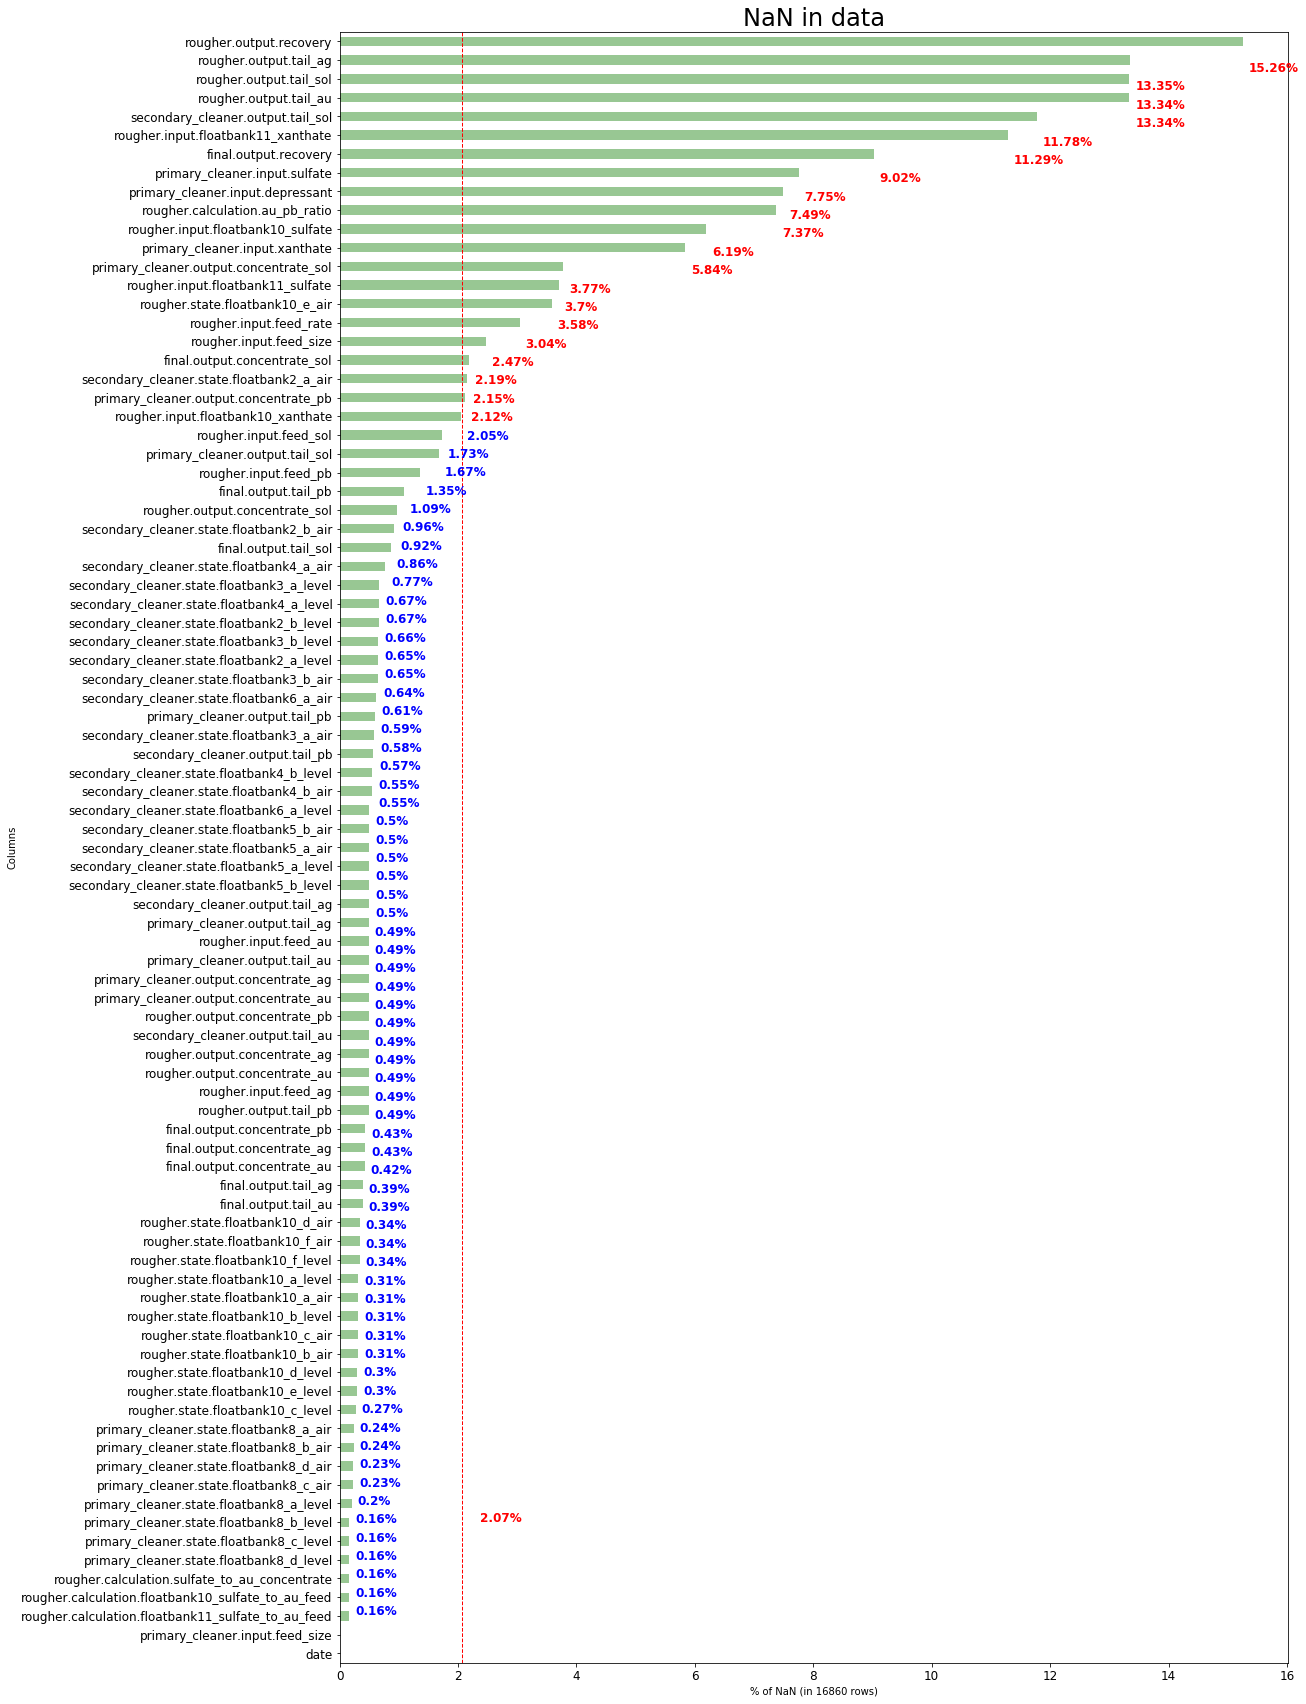

In [25]:
def percent_hbar(df, old_threshold = None):
    percent_of_nulls = (df.isnull().sum()/len(df)*100).sort_values().round(2)
    threshold = percent_of_nulls.mean()
    ax = percent_of_nulls.plot(kind = 'barh', figsize = (17, 30), 
                               color = '#98c793', legend = False, fontsize = 12)
    ax.set_xlabel('Count of NaN')
    dict_percent = dict(percent_of_nulls)
    i = 0
    for k in dict_percent:
        color = 'blue'
        if dict_percent[k] > 0:
            if dict_percent[k] > threshold:
                color = 'red'
            ax.text(dict_percent[k]+0.1, i + 0.09, str(dict_percent[k])+'%', color = color, 
                    fontweight = 'bold', fontsize = 'large')
        i += 0.98
    if old_threshold is not None:
        plt.axvline(x = old_threshold, linewidth = 1, color = 'r', linestyle = '--')
        ax.text(old_threshold + 0.3, 10, '{0:.2%}'.format(old_threshold / 100), color = 'r', fontweight = 'bold', fontsize = 'large')
        plt.axvline(x = threshold, linewidth = 1, color = 'green', linestyle = '--')
        ax.text(threshold + 0.3, 7, '{0:.2%}'.format(threshold / 100), color = 'green', fontweight = 'bold', fontsize = 'large')
    else:
        plt.axvline(x = threshold, linewidth = 1, color = 'r', linestyle = '--')
        ax.text(threshold + 0.3, 7, '{0:.2%}'.format(threshold / 100), color = 'r', fontweight = 'bold', fontsize = 'large')
    ax.set_xlabel('% of NaN (in {} rows)'.format(len(df)))
    ax.set_ylabel('Columns')
    plt.title(label = 'NaN in data', fontsize = 24)
    return ax, threshold

plot, threshold = percent_hbar(gold_recovery_train)

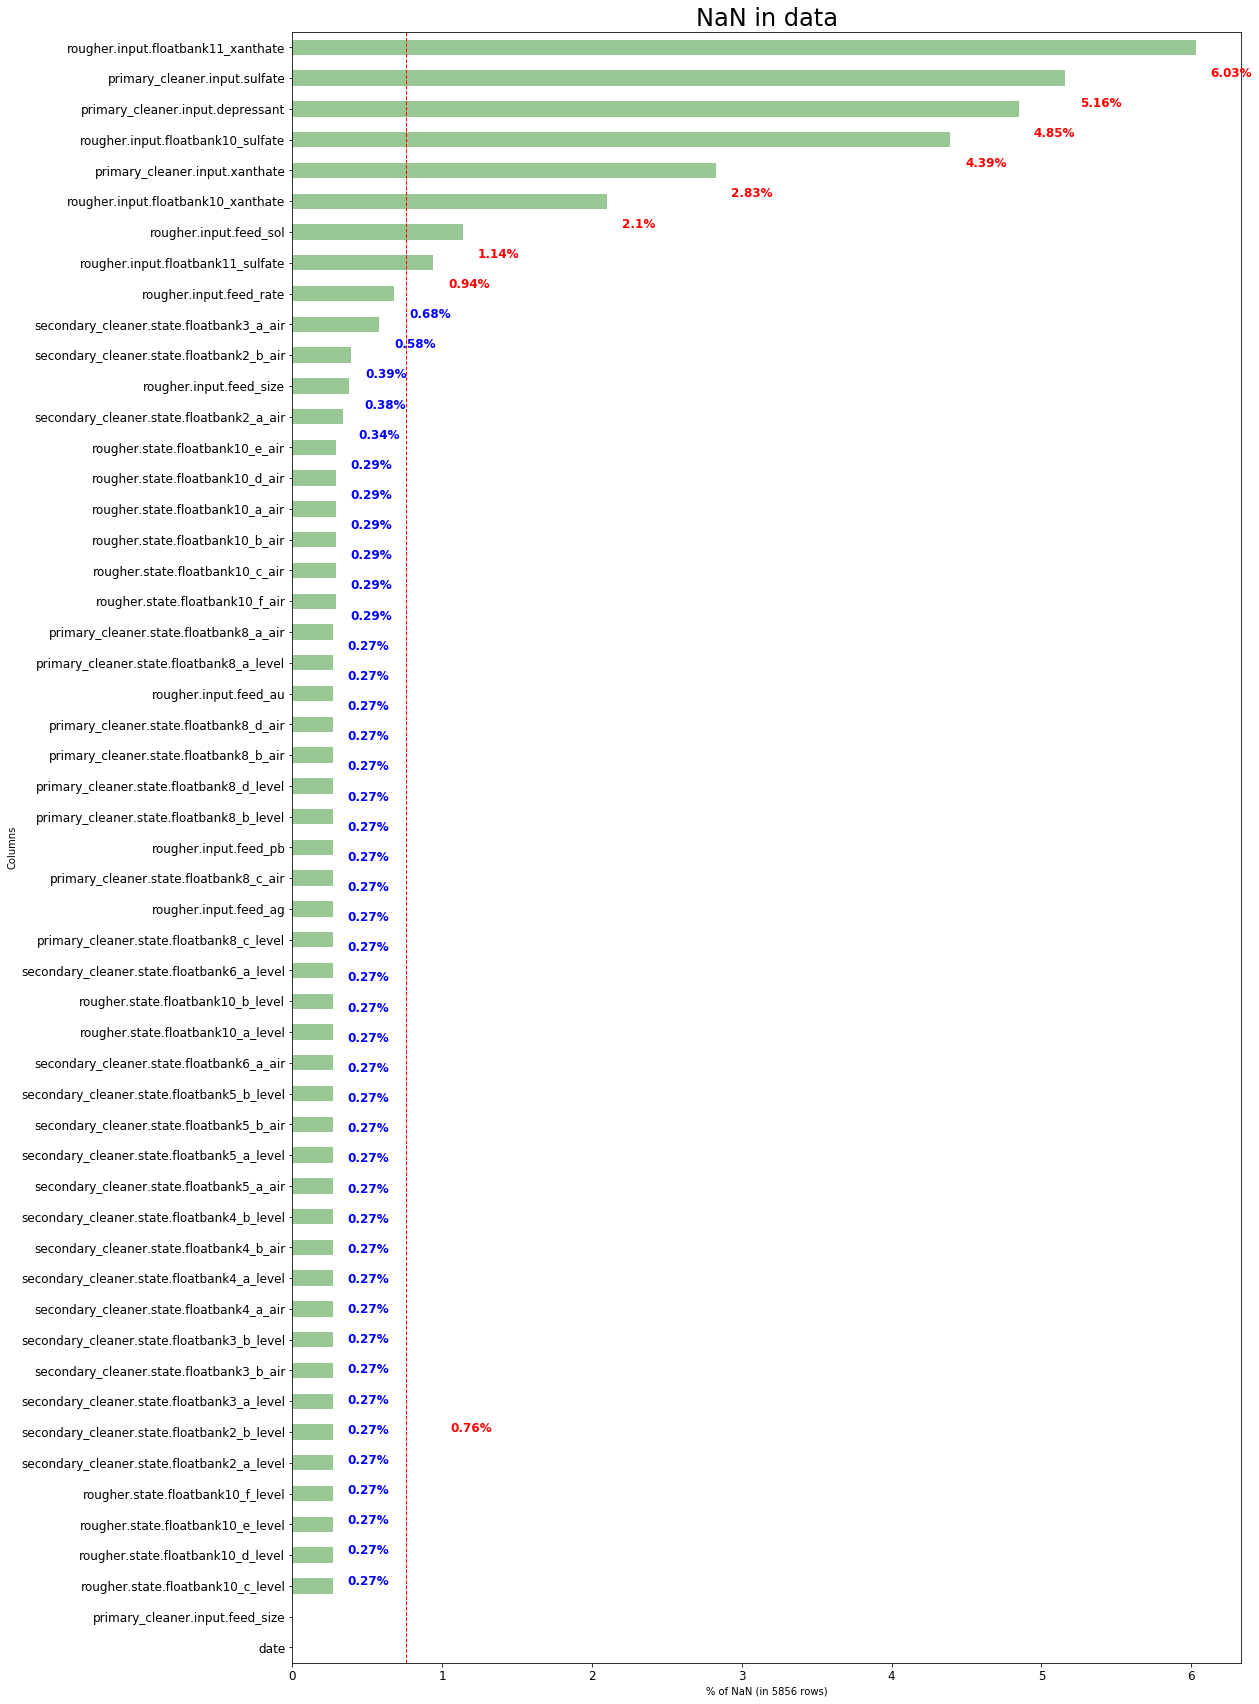

In [26]:
plot, threshold = percent_hbar(gold_recovery_test)

Не самое ужасное, конечно, положение, однако...   
Краткие итоги.   

Тренировочная выборка:   
- среднее значение пропусков - 2,07%;   
- максимальное - 15,26%.   
С тренировочной определённо надо хорошо поработать.   
   
Тестовая выборка:   
- среднее значение пропусков - 1,23%;   
- максимальное - 9,32%;   
Лучше, чем в тренировочной. В любом случае с этим надо работать. Отработаем способы на тренировочной, и если хорошо себя покажут - применим на тестовой. Хотя есть мысль что можно и дропнуть в тестовой, главное обучить на большой и качественной выборке. Всё-таки 6% в целом не так много, и при этом мы будем уверены в достоверности данных, по которым будем предсказывать. В общем далее посмотрим.

Идея, что можно сделать в обучающей выборке для обработки пропусков:
В ТЗ сказано, что соседние по времени параметры часто похожи. Что вполне логично для условий описанного технологического процесса. И с учетом того, какие данные у нас отсутствуют - логичным будет следующее:
- добавим колонки с годом, месяцем, днем, часами и минутами;   
- для каждого дня каждого месяца каждого года заполним пропуски медианным значением по часам.   

P.s.: предварительный анализ сделан. Рузельтаты опишем далее по коду.

Добавляем новые колонки.

In [27]:
gold_recovery_train['year'] = pd.DatetimeIndex(gold_recovery_train['date']).year
gold_recovery_train['month'] = pd.DatetimeIndex(gold_recovery_train['date']).month
gold_recovery_train['day'] = pd.DatetimeIndex(gold_recovery_train['date']).day
gold_recovery_train['hour'] = pd.DatetimeIndex(gold_recovery_train['date']).hour
gold_recovery_train['minute'] = pd.DatetimeIndex(gold_recovery_train['date']).minute

In [28]:
gold_recovery_train['minute'].unique()

array([ 0, 59])

Выше в выборке по данным видели только минуты, равные 0 и 59, значит логичным будет для 59 минут округлить часы в +1 (при этом полученные 24 часа и оставшиеся 59 минут заменим на 0).

In [29]:
gold_recovery_train.loc[gold_recovery_train['minute'] == 59, 'hour'] = gold_recovery_train['hour'] + 1
gold_recovery_train.loc[gold_recovery_train['minute'] == 59, 'minute'] = 0
gold_recovery_train.loc[gold_recovery_train['hour'] == 24, 'hour'] = 0

In [30]:
#gold_recovery_train['minute'].unique()

Привели время к удобному для взятия срезов виду.   
Ради интереса посмотрим респределение нескольких параметров как по месяцу, так и в течение дня.

In [31]:
test2016 = gold_recovery_train.query('year == "2016"')

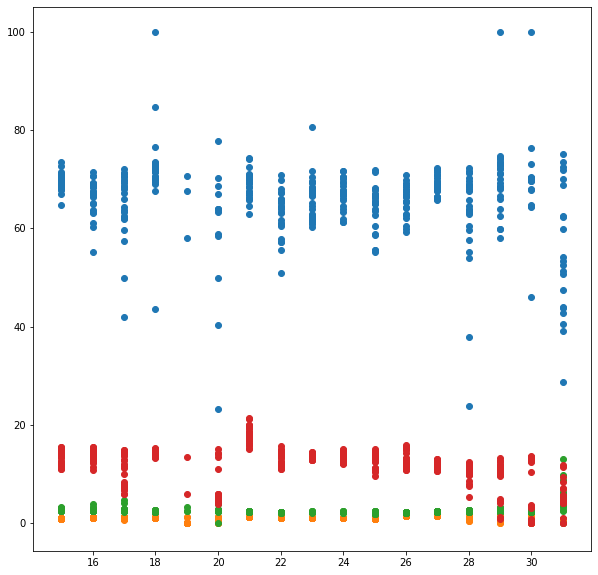

In [32]:
test_columns = ['final.output.recovery', 'primary_cleaner.input.xanthate', 'rougher.calculation.au_pb_ratio', 'rougher.input.floatbank10_sulfate']
plt.figure(figsize = (10,10))
for i in test_columns:
    plt.scatter(test2016[test2016['month'] == 1]['day'], test2016[test2016['month'] == 1][i])

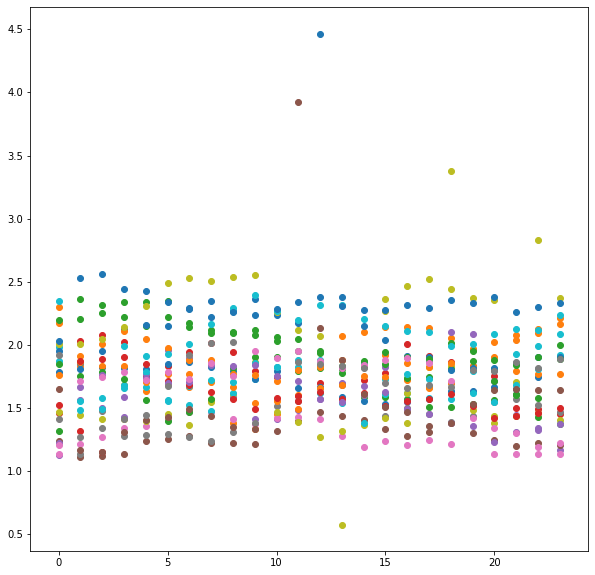

In [33]:
test2 = gold_recovery_train.query('year == "2017" and month == "1"')
plt.figure(figsize = (10,10))
for i in range(31):
    plt.scatter(test2[test2['day'] == i]['hour'], test2[test2['day'] == i]['rougher.output.tail_au'])

Были рассмотрены несколько зависимостей признаков от времени, везде картина разброса примерно одинаковая. При этом присутствуют выбросы, но от них мы избавимся далее. В целом картина показывает возможность замены пропусков медианными значениями. Займёмся этим.

In [34]:
columns_to_fillna = gold_recovery_train.columns
columns_to_fillna = columns_to_fillna.drop(['date','year','month','day', 'hour', 'minute'])
#display(columns_to_fillna)

In [35]:
for i in (columns_to_fillna):
    gold_recovery_train[i] = gold_recovery_train.groupby(['year','month','day','hour'])[i].fillna(gold_recovery_train[i].median())

In [36]:
#gold_recovery_train.info()

Пропуски заполнены. Селаем то же самое для тестовой выборки.

In [37]:
gold_recovery_test['year'] = pd.DatetimeIndex(gold_recovery_test['date']).year
gold_recovery_test['month'] = pd.DatetimeIndex(gold_recovery_test['date']).month
gold_recovery_test['day'] = pd.DatetimeIndex(gold_recovery_test['date']).day
gold_recovery_test['hour'] = pd.DatetimeIndex(gold_recovery_test['date']).hour
gold_recovery_test['minute'] = pd.DatetimeIndex(gold_recovery_test['date']).minute
gold_recovery_test.loc[gold_recovery_test['minute'] == 59, 'hour'] = gold_recovery_train['hour'] + 1
gold_recovery_test.loc[gold_recovery_test['minute'] == 59, 'minute'] = 0
gold_recovery_test.loc[gold_recovery_test['hour'] == 24, 'hour'] = 0

In [38]:
columns_to_fillna = gold_recovery_test.columns
columns_to_fillna = columns_to_fillna.drop(['date','year','month','day', 'hour', 'minute'])

In [39]:
for i in (columns_to_fillna):
    gold_recovery_test[i] = gold_recovery_test.groupby(['year','month','day','hour'])[i].fillna(gold_recovery_test[i].median())

In [40]:
#gold_recovery_test.info()

Пока предобработка закончена. На следующем шаге ещё будут отброшены аномальные значения.   
Проверка (закомментированная) показала что пропуски отсутствуют, кроме того при перезапуске диаграмм выше видно, что заполнение не сильно повлияло на распределение значений во времени.

___
[*К содержанию*](#back)

<a id = '2'></a>
# 2. Анализ данных
___
___

<a id = '2.1'></a>
### 2.1. Анализ изменения концентрации металлов на различных этапах очистки
___

Проще всего проводить графический анализ. Создадим для это отдельный DataFrame с необходимыми данными. В данном случае нас интересуют концентрации каждого металла на каждом этапе очистки. Так что из исходного набора данных новый создадим добавлением колонок, в которых есть слово 'concetrate' и нет 'sol'.

In [41]:
columns_list = []
for column in (gold_recovery_train.columns):
    if ('concentrate' in column and 'sol' not in column):
        columns_list.append(column)
        
concentrate_data = gold_recovery_train[columns_list]
concentrate_data.drop('rougher.calculation.sulfate_to_au_concentrate', axis = 1, inplace = True)

In [42]:
#concentrate_data.info()

Получили необходимый датафрем, дропнули одну ненужную колонку сразу.

Text(0, 0.5, 'Metall concentration, %')

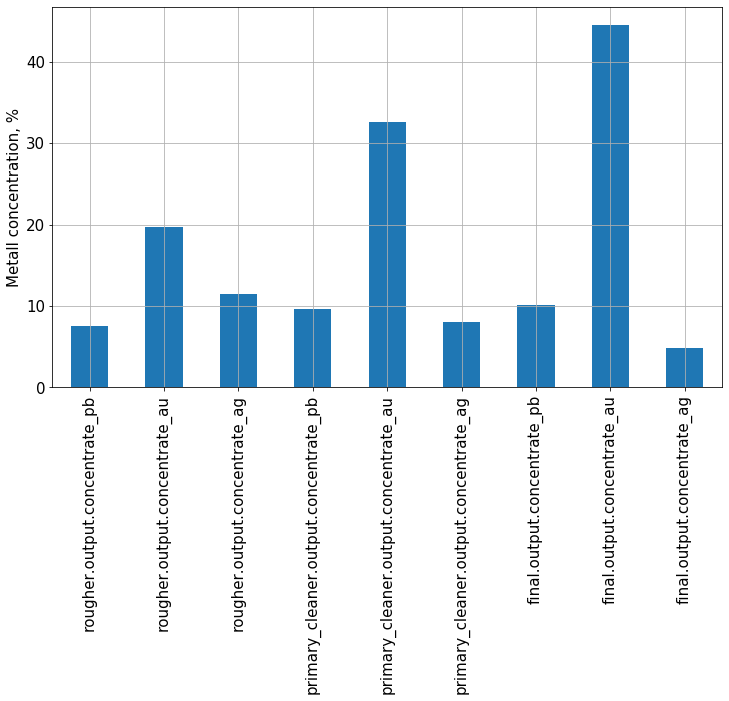

In [43]:
y = concentrate_data.median()
y.sort_index(ascending = False, inplace = True)
plt.figure(figsize = (12,7))
ax = y.plot(kind = 'bar', grid = True, fontsize = 15)
ax.set_ylabel('Metall concentration, %', fontsize = 15)

По оставшимся данным построили Series, с медианными значениями концентрации каждого металла для каждого этапа процесса. Медианное взято с предположением о том, что процесс во времени не должен был сильно меняться, при этом медианные значения не будут учитывать выбросы.   
Видим следующее:   
- самое главное, что концентрация золота на выходе каждого этапа растёт. Отлично, это то, что нам и надо;   
- так же растет концентрация свинца, но незначительно. Возможно свинец - один из побочных продуктов очистки руды, возможно что он добавляется исскуственно для определенных процессов. Нам это не сказано в задании, значит не учитываем;
- концентрация серебра наоборот, падает. В принципе серебро - не наша цель, так что отношение у нас к нему как к свинцу.

___
[*К содержанию*](#back)

<a id = '2.2'></a>
### 2.2. Сравнение распределения размеров гранул сырья на выборках
___

Для оценки этого параметра лучше использовать боксплоты. Размеры гранул сырья в наборах данных представлены параметром `feed_size`. Поступим как в прошлый раз, объединим необходимые дынные для удобства работы с ними. В обоих наборах данных размеры гранул сырья представлены в колонках `primary_cleaner.input.feed_size` и `rougher.input.feed_size`.

In [44]:
feed_size = pd.DataFrame()
feed_size['train_rougher'] = gold_recovery_train['rougher.input.feed_size']
feed_size['train_primary'] = gold_recovery_train['primary_cleaner.input.feed_size']
feed_size['test_rougher'] = gold_recovery_test['rougher.input.feed_size']
feed_size['test_primary'] = gold_recovery_test['primary_cleaner.input.feed_size']
feed_size.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 4 columns):
train_rougher    16860 non-null float64
train_primary    16860 non-null float64
test_rougher     5856 non-null float64
test_primary     5856 non-null float64
dtypes: float64(4)
memory usage: 527.0 KB


(15, 100)

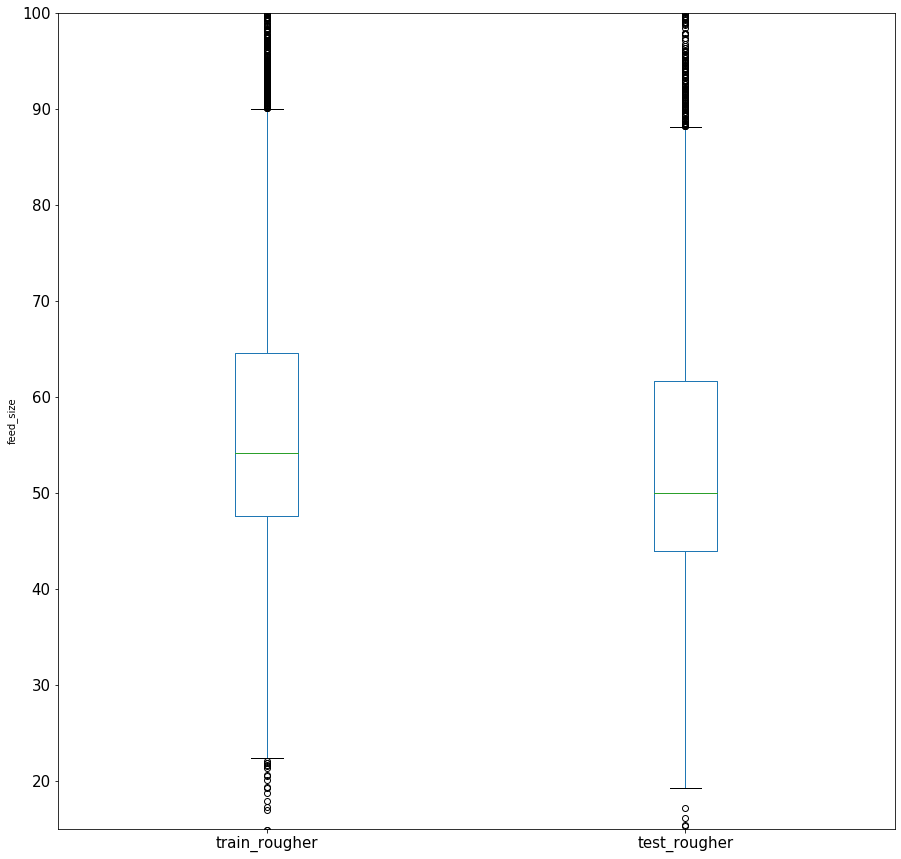

In [45]:
ax = feed_size[['train_rougher','test_rougher']].plot(kind = 'box', fontsize = 15, figsize = (15,15))
ax.set_ylabel('feed_size')
ax.set_ylim(15, 100)

(5, 10)

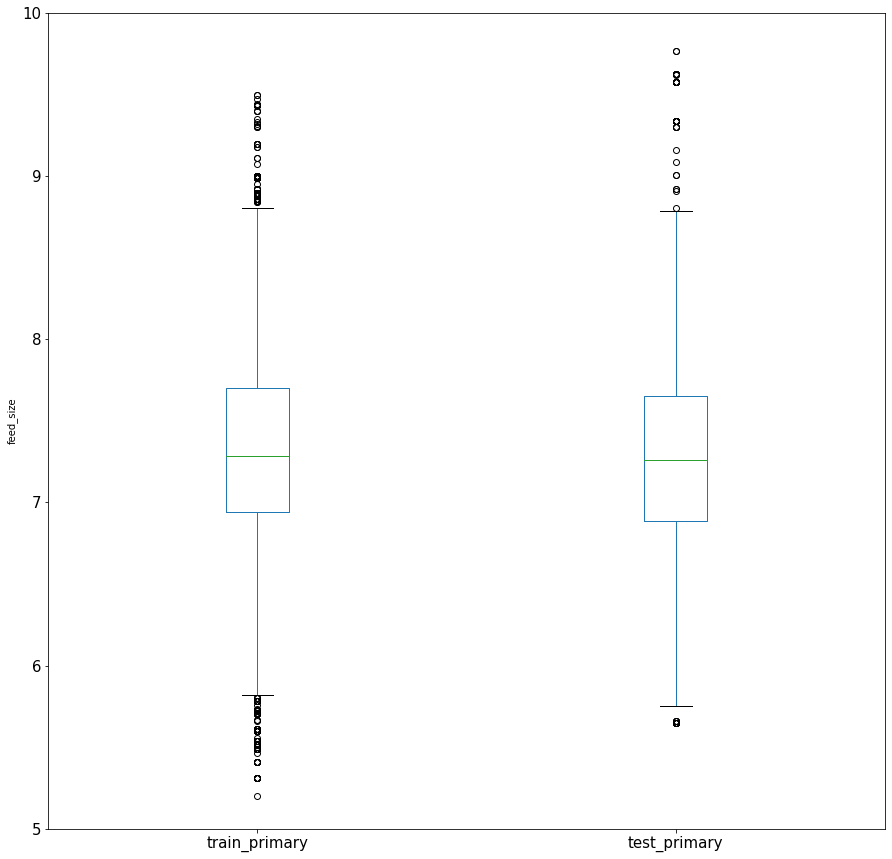

In [46]:
ax = feed_size[['train_primary','test_primary']].plot(kind = 'box', fontsize = 15, figsize = (15,15))
ax.set_ylabel('feed_size')
ax.set_ylim(5, 10)

Мы видим что для каждого процесса в каждом набора данных распределение размеров гранул не сильно отличается друг от друга. Значит не стоит переживать о том, что оценка модели может быть неправильна из-за большой разницы в распределении, как нас предупреждали в задании.   
Для интереса еще посмотрим эти же данные методом `describe` с измененными перцентилями.

In [47]:
feed_size.describe(percentiles = [.05, .5, .95])

,train_rougher,train_primary,test_rougher,test_primary
count,16860.000000,16860.000000,5856.000000,5856.000000
mean,58.563359,7.297285,55.915236,7.264651
std,23.635551,0.619166,22.684428,0.611526
min,9.659576,1.080000,0.046369,5.650000
5%,37.031693,6.323242,40.493328,6.300000
50%,54.104257,7.285000,50.002004,7.259333
95%,84.768299,8.340000,85.984325,8.244375
max,484.967466,10.470000,477.445473,15.500000


Собственно что и требовалось даказать. Значения 5-ти, 50-ти и 95-ти процентилей довольно близки друг другу для каждого процесса.

___
[*К содержанию*](#back)

<a id = '2.3'></a>
### 2.3. Исследование суммарной концентрации всех веществ на разных стадиях процесса
___

В принципе, для такого исследования нам необходимо повторить шаги из пункта 2.1, за исключением того, что не будем дропать соли, и будем исследовать значения суммы, а не медианные.

In [48]:
columns_list = []
for column in (gold_recovery_train.columns):
    if ('concentrate' in column):
        columns_list.append(column)
        
concentrate_data = gold_recovery_train[columns_list]
concentrate_data.drop('rougher.calculation.sulfate_to_au_concentrate', axis = 1, inplace = True)

Text(0, 0.5, 'Metall concentration')

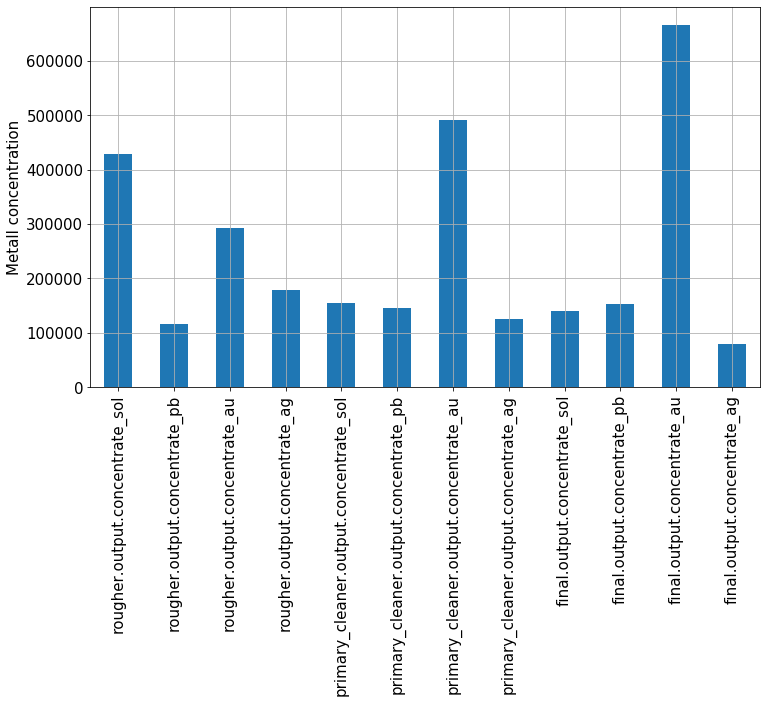

In [49]:
y = concentrate_data.sum()
y.sort_index(ascending = False, inplace = True)
plt.figure(figsize = (12,7))
ax = y.plot(kind = 'bar', grid = True, fontsize = 15)
ax.set_ylabel('Metall concentration', fontsize = 15)

Собственно... Картина та же самая, что и при исследовании концентрации только металлов. Посмотрим на картину немножко по другому. Возможно! Что в задании имелось в виду просуввировать концентрацию каждого вещества между собой для каждого этапа. Зайдем с этой стороны.

In [50]:
concentrate_data_sum = pd.DataFrame()
concentrate_data_sum['rougher'] = concentrate_data['rougher.output.concentrate_ag'] + concentrate_data['rougher.output.concentrate_pb'] + concentrate_data['rougher.output.concentrate_sol'] + concentrate_data['rougher.output.concentrate_au']
concentrate_data_sum['primary'] = concentrate_data['primary_cleaner.output.concentrate_ag'] + concentrate_data['primary_cleaner.output.concentrate_pb'] + concentrate_data['primary_cleaner.output.concentrate_sol'] + concentrate_data['primary_cleaner.output.concentrate_au']
concentrate_data_sum['final'] = concentrate_data['final.output.concentrate_ag'] + concentrate_data['final.output.concentrate_pb'] + concentrate_data['final.output.concentrate_sol'] + concentrate_data['final.output.concentrate_au']
concentrate_data_sum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 3 columns):
rougher    16860 non-null float64
primary    16860 non-null float64
final      16860 non-null float64
dtypes: float64(3)
memory usage: 395.3 KB


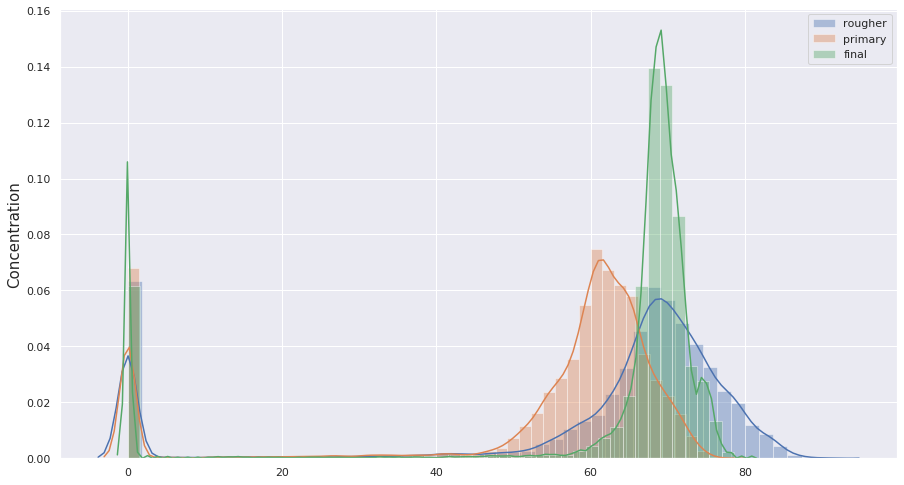

In [51]:
legend_list = []
sns.set(rc={'figure.figsize':(15,8.27)})
for column in concentrate_data_sum.columns:
    legend_list.append(column)
    ax = sns.distplot(concentrate_data_sum[column])
    ax.set_ylabel('Concentration', fontsize = 15)
    ax.set_xlabel('')
    ax.legend(legend_list)

Вооот, теперь мы видим в качестве аномальных значений нули в концентрациях. Будем избавляться. При этом в тестовой выборке отсутствуют данные о концентрациях, так что избавляться там не от чего. Чистим тренировочную.

In [52]:
gold_recovery_train['rougher'] = gold_recovery_train['rougher.output.concentrate_ag'] + gold_recovery_train['rougher.output.concentrate_pb'] + gold_recovery_train['rougher.output.concentrate_sol'] + gold_recovery_train['rougher.output.concentrate_au']
gold_recovery_train['primary'] = gold_recovery_train['primary_cleaner.output.concentrate_ag'] + gold_recovery_train['primary_cleaner.output.concentrate_pb'] + gold_recovery_train['primary_cleaner.output.concentrate_sol'] + gold_recovery_train['primary_cleaner.output.concentrate_au']
gold_recovery_train['final'] = gold_recovery_train['final.output.concentrate_ag'] + gold_recovery_train['final.output.concentrate_pb'] + gold_recovery_train['final.output.concentrate_sol'] + gold_recovery_train['final.output.concentrate_au']

In [53]:
gold_recovery_train = gold_recovery_train.loc[gold_recovery_train['rougher'] != 0]
gold_recovery_train = gold_recovery_train.loc[gold_recovery_train['primary'] != 0]
gold_recovery_train = gold_recovery_train.loc[gold_recovery_train['final'] != 0]

In [54]:
#gold_recovery_test['rougher'] = gold_recovery_test['rougher.output.concentrate_ag'] + gold_recovery_test['rougher.output.concentrate_pb'] + gold_recovery_test['rougher.output.concentrate_sol'] + gold_recovery_test['rougher.output.concentrate_au']
#gold_recovery_test['primary'] = gold_recovery_test['primary_cleaner.output.concentrate_ag'] + gold_recovery_test['primary_cleaner.output.concentrate_pb'] + gold_recovery_test['primary_cleaner.output.concentrate_sol'] + gold_recovery_test['primary_cleaner.output.concentrate_au']
#gold_recovery_test['final'] = gold_recovery_test['final.output.concentrate_ag'] + gold_recovery_test['final.output.concentrate_pb'] + gold_recovery_test['final.output.concentrate_sol'] + gold_recovery_test['final.output.concentrate_au']

In [55]:
#gold_recovery_test = gold_recovery_test.loc[gold_recovery_test['rougher'] != 0]
#gold_recovery_test = gold_recovery_test.loc[gold_recovery_test['primary'] != 0]
#gold_recovery_test = gold_recovery_test.loc[gold_recovery_test['final'] != 0]

Работа выполнена)

___
[*К содержанию*](#back)

<a id = '3'></a>
# 3. Модель
___
___

<a id = '3.1'></a>
### 3.1. Функция для вычисления итоговой sMAPE
___

Напишем две функции, обычную sMAPE и итоговую. Первую просто потом подставим во вторую.

In [56]:
def sMAPE(predictions, target):
    sMAPE = sum((100 * (abs(target - predictions)) / ((abs(target) + abs(predictions)) / 2))) / len(predictions)
    
    return sMAPE

In [57]:
def final_sMAPE(rougher, final):
    final_sMAPE = 0.25 * rougher + 0.75 * final
    
    return final_sMAPE

Функции написаны.

___
[*К содержанию*](#back)

<a id = '3.2'></a>
### 3.2. Обучение моделей и оценка качества кросс-валидацией
___

In [58]:
merge_data = gold_recovery_full[['date', 'rougher.output.recovery', 'final.output.recovery']]
gold_recovery_test = gold_recovery_test.merge(merge_data, on = 'date')

In [59]:
col_list_test = gold_recovery_test.columns
col_list_train = gold_recovery_train.columns
for column in col_list_train:
    if column not in col_list_test:
        gold_recovery_train.drop(column, axis = 1, inplace = True)

Тут пришлось еще раз обработать пропуски, так как при их наличии - sMAPE получались nan-овские)

In [60]:
for i in (['rougher.output.recovery','final.output.recovery']):
    gold_recovery_test[i] = gold_recovery_test.groupby(['year','month','day','hour'])[i].fillna(gold_recovery_test[i].median())

Перед нами стоит задача регрессии. Соответственно необходимо использовать регрессионные модели.
Кроме того необходимо спрогнозировать сразу две величины, следовательно для каждго вида модели необходимо создавать по две модели. Предлагается использовать `LinearRegression` и `RandomForestRegressor`.

Подготовим обучающие и целевые признаки. При этом стоит из исходной выборки удалить некоторые колонки, которые мы использовали для промежуточной оценки. В частности, удалить колонку 'date', но оставить год, месяц, день и час, которые мы вынесли в отдельные колонки.

In [61]:
gold_recovery_train.drop(['date', 'minute'], axis = 1, inplace = True)
gold_recovery_test.drop(['date', 'minute'], axis = 1, inplace = True)

In [62]:
train = gold_recovery_train.drop(['rougher.output.recovery', 'final.output.recovery'], axis = 1)
target_rougher = gold_recovery_train['rougher.output.recovery']
target_final = gold_recovery_train['final.output.recovery']
test = gold_recovery_test.drop(['rougher.output.recovery', 'final.output.recovery'], axis = 1)
test_target_rougher = gold_recovery_test['rougher.output.recovery']
test_target_final = gold_recovery_test['final.output.recovery']

In [63]:
print(test_target_final.isna().sum())

0


In [64]:
rf_model = RandomForestRegressor(random_state = 481516, n_estimators=2, max_depth=2)
rf_model.fit(train, target_rougher)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=2, n_jobs=None,
                      oob_score=False, random_state=481516, verbose=0,
                      warm_start=False)

In [65]:
rl_model = LinearRegression()
rl_model.fit(train, target_rougher)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [66]:
ff_model = RandomForestRegressor(random_state = 481516, n_estimators=2, max_depth=2)
ff_model.fit(train, target_final)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=2, n_jobs=None,
                      oob_score=False, random_state=481516, verbose=0,
                      warm_start=False)

In [67]:
fl_model = LinearRegression()
fl_model.fit(train, target_final)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [68]:
rf_final_score = statistics.mean(cross_val_score(rf_model, train, target_rougher, cv = 5))
print(rf_final_score)

-0.3450691233373308


In [69]:
rl_final_score = statistics.mean(cross_val_score(rl_model, train, target_rougher, cv = 5))
print(rl_final_score)

-0.017247321413157768


In [70]:
ff_final_score = statistics.mean(cross_val_score(ff_model, train, target_final, cv = 5))
print(ff_final_score)

0.08623659608976512


In [71]:
fl_final_score = statistics.mean(cross_val_score(fl_model, train, target_final, cv = 5))
print(fl_final_score)

-0.2497284911549258


In [72]:
from sklearn.linear_model import SGDRegressor

knr_model_r = SGDRegressor()
knr_model_f = SGDRegressor()

knr_model_r.fit(train, target_rougher)
knr_model_f.fit(train, target_final)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [73]:
knr_r_pred = knr_model_r.predict(test)
knr_f_pred = knr_model_f.predict(test)

В обоих случаях лучше себя показала модель случайного леса. Получим предсказания по тестовой выборке и рассчитаем финальную sMAPE.

In [74]:
ror_pred = rf_model.predict(test)
for_pred = ff_model.predict(test)

In [75]:
smape_r = sMAPE(ror_pred, test_target_rougher)
smape_f = sMAPE(for_pred, test_target_final)

In [76]:
print('Значение final_sMAPE:', final_sMAPE(smape_r, smape_f))

Значение final_sMAPE: 9.24100786994142


Что ж.
Данные были предобработаны, модели обучены.   
Итоговое значение sMAPE не сильно большое, для поставленной нам задачи.   
Конечно, в идеале - меньше, однако имея дело с такой вещью как обработка руды, где очень много зависит от первичного сырья особенно во времени.

In [77]:
target_pred_constant_r = pd.Series(np.full(shape = (len(test_target_rougher)), fill_value = test_target_rougher.mean()))
target_pred_constant_f = pd.Series(np.full(shape = (len(test_target_final)), fill_value = test_target_final.mean()))
print(len(target_pred_constant_r), len(target_pred_constant_f))

5856 5856


In [78]:
smape_r = sMAPE(target_pred_constant_r, test_target_rougher)
smape_f = sMAPE(target_pred_constant_f, test_target_final)

In [79]:
print('Значение final_sMAPE на константной модели:', final_sMAPE(smape_r, smape_f))

Значение final_sMAPE на константной модели: 9.366704674844904


Значение по константной модели на 0.12 больше, чем модели леса. Победа)

___
[*К содержанию*](#back)